# Data Collection

### Downloading data

In [789]:
# python download_data.py

### Combining data from all chunks into one file

In [790]:
# cat data/offers_data*.txt | grep -v '"error"' > data/offers_data.txt

# Data Cleaning & Preparation

### Importing libraries and configuring settings

In [791]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

from math import ceil

In [792]:
pd.set_option('display.max_columns', None)

### Loading and reviewing data

In [793]:
df = pd.read_json('data/offers_data.txt', lines=True)

In [794]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91712 entries, 0 to 91711
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   street              54322 non-null  object 
 1   equipment           27034 non-null  object 
 2   areas               79487 non-null  object 
 3   floor               89648 non-null  object 
 4   kitchen             17296 non-null  object 
 5   parking             0 non-null      float64
 6   numberOfRooms       91712 non-null  int64  
 7   rooms               0 non-null      float64
 8   type                72648 non-null  object 
 9   windowsOrientation  0 non-null      float64
 10  year                67677 non-null  float64
 11  material            44438 non-null  object 
 12  windows             54138 non-null  object 
 13  heating             65621 non-null  object 
 14  numberOfFloors      83861 non-null  float64
 15  conveniences        58185 non-null  object 
 16  secu

In [795]:
df.isnull().mean().sort_values(ascending=False)

parking               1.000000
rooms                 1.000000
windowsOrientation    1.000000
free_from             0.854915
kitchen               0.811410
equipment             0.705229
rent_currency         0.603138
rent                  0.603138
media_types           0.573349
material              0.515461
security              0.443999
windows               0.409696
street                0.407689
conveniences          0.365568
heating               0.284488
year                  0.262070
ownership             0.241604
condition             0.233001
type                  0.207868
areas                 0.133298
numberOfFloors        0.085605
lift                  0.079870
ad_price              0.053232
floor                 0.022505
long                  0.000000
price_currency        0.000000
city_name             0.000000
lat                   0.000000
region_name           0.000000
subregion_id          0.000000
area                  0.000000
propertype            0.000000
user_typ

- renaming columns

In [796]:
df['number_of_rooms'] = df.numberOfRooms
df['number_of_floors'] = df.numberOfFloors
df['building_type'] = df.type
df['windows_orientation'] = df.windowsOrientation
df = df.drop(columns=['numberOfRooms', 'numberOfFloors', 'type', 'windowsOrientation'])

### Imputing missing values

#### equipment, areas, conveniences, security, media_types

**Analysis:**
- columns with list-like comma-separated string values

**Decision:**
- create separate column for each unique characteristic
- treat null values as lacking of specific characteristic

In [797]:
multiple_values_columns = ['equipment', 'areas', 'conveniences', 'security', 'media_types']
for column in multiple_values_columns:
    types = df[column].dropna().apply(lambda x: x.split(', ') if x else None).explode().unique()
    for t in types:
        df[t] = df[column].apply(lambda x: 1 if x is not None and t in x else 0)
df = df.drop(columns=multiple_values_columns)

- removing duplicated columns added during creation

In [798]:
(df['INTERNET'] == df['internet']).all()

True

In [799]:
df = df.drop(columns=['internet'])

In [800]:
df.loc[df['lift'].isnull(), 'lift'] = df['LIFT']
df['lift'].replace({'y': 1, 'n': 0}, inplace=True)
(df['LIFT'] == df['lift']).all()

True

In [801]:
df = df.drop(columns=['lift'])

#### kitchen

In [802]:
df.kitchen.unique()

array([None, 'SEPARATE'], dtype=object)

**Analysis:**
- only one unique value is present: SEPERATE

**Decision:**
- create separate_kitchen column with values:
  - 0 - non-separate
  - 1 - separate 
- treat null values as 0 - non-separate

In [803]:
df['separate_kitchen'] = df.kitchen.map(lambda k: 1 if k else 0)
df = df.drop(columns=['kitchen'])

### heating

In [804]:
building_type_grp = df.groupby(['building_type'])
building_type_grp['heating'].value_counts(normalize=True)

building_type  heating    
APARTMENT      URBAN          0.735046
               GAS            0.148202
               OTHER          0.071283
               BOILER_ROOM    0.028369
               ELECTRICAL     0.016969
               TILED_STOVE    0.000131
BLOCK          URBAN          0.806867
               GAS            0.114169
               OTHER          0.046790
               BOILER_ROOM    0.022180
               ELECTRICAL     0.008734
               TILED_STOVE    0.001261
HOUSE          GAS            0.540778
               OTHER          0.210790
               URBAN          0.114806
               BOILER_ROOM    0.064617
               ELECTRICAL     0.056462
               TILED_STOVE    0.012547
INFILL         URBAN          0.855263
               GAS            0.078947
               BOILER_ROOM    0.039474
               OTHER          0.013158
               ELECTRICAL     0.013158
LOFT           URBAN          0.808219
               GAS            0.16438

**Analysis:**
- 28% of values are null
- different building types generally exhibit a preference for specific heating types over others

**Decision**: 
- fillna using the mode value associated with each building type
- if obtaining the mode value for a specific building type is not possible, use the mode value corresponding to the entire dataset

In [805]:
for building_type in df.building_type.dropna().unique():
    heating_mode = df[df['building_type'] == building_type]['heating'].mode()
    heating_mode = heating_mode[0] if heating_mode.any() else df['heating'].mode()[0]
    df.loc[df['building_type'] == building_type, 'heating'] = df['heating'].fillna(heating_mode)

### windows, ownership

In [806]:
df.windows.value_counts(normalize=True)

windows
PLASTIC      0.920444
WOODEN       0.065259
ALUMINIUM    0.014297
Name: proportion, dtype: float64

In [807]:
df.ownership.value_counts(normalize=True)

ownership
FULL_OWNERSHIP            0.948874
LIMITED_OWNERSHIP         0.046266
SHARE                     0.004026
USUFRUCT                  0.000820
CO_OPERATIVE_OWNERSHIP    0.000014
Name: proportion, dtype: float64

**Analysis:**
- one value significantly dominates, representing over 90% of occurrences compared to the others

**Decision:** 
- fillna using the mode value corresponding to the entire dataset

In [808]:
df.windows.fillna(df.windows.mode()[0], inplace=True)
df.ownership.fillna(df.ownership.mode()[0], inplace=True)

### parking, rooms, windows_orientation, free_from, rent, rent_currency, material, street, year, condition, building_type, number_of_floors, ad_price, floor

**Analysis:**
- no resonable methods of imputation where identified

## Cleaning data

In [809]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91712 entries, 0 to 91711
Data columns (total 59 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   street               54322 non-null  object 
 1   floor                89648 non-null  object 
 2   parking              0 non-null      float64
 3   rooms                0 non-null      float64
 4   year                 67677 non-null  float64
 5   material             44438 non-null  object 
 6   windows              91712 non-null  object 
 7   heating              77767 non-null  object 
 8   condition            70343 non-null  object 
 9   ownership            91712 non-null  object 
 10  rent                 36397 non-null  float64
 11  rent_currency        36397 non-null  object 
 12  lat                  91712 non-null  float64
 13  long                 91712 non-null  float64
 14  ad_price             86830 non-null  float64
 15  price_currency       91712 non-null 

In [810]:
df.isnull().mean().sort_values(ascending=False)

parking                1.000000
rooms                  1.000000
windows_orientation    1.000000
free_from              0.854915
rent                   0.603138
rent_currency          0.603138
material               0.515461
street                 0.407689
year                   0.262070
condition              0.233001
building_type          0.207868
heating                0.152052
number_of_floors       0.085605
ad_price               0.053232
floor                  0.022505
garage                 0.000000
garden                 0.000000
ENTRYPHONE             0.000000
terrace                0.000000
usable_room            0.000000
INTERNET               0.000000
LIFT                   0.000000
MONITORING             0.000000
ALARM                  0.000000
CLOSED_AREA            0.000000
ROLLER_SHUTTERS        0.000000
ANTI_BURGLARY_DOOR     0.000000
balcony                0.000000
cable-television       0.000000
phone                  0.000000
cable_television       0.000000
electric

In [811]:
unique_counts = df.nunique()
columns_with_one_unique_value = unique_counts[unique_counts == 1].index.tolist()
columns_with_one_unique_value

['propertype', 'offertype']

##### Analysis:
- parking, rooms, windows_orientation, free_from, rent, rent_currency, material - over 50% of null values
- price_currency, propertype, offertype - only one unique value
- street - 41% null values
- year, condition, building_type, heating - less than 30% of null values
- number_of_floors, ad_price, floor - less than 1% of null values
##### Decision:
- parking, rooms, windows_orientation, free_from, rent, rent_currency, material, propertype, offertype - drop entire columns
- street, year, condition, building_type, heating, number_of_floors, ad_price, floor - dropna

In [812]:
df = df.drop(columns=['parking', 'rooms', 'windows_orientation', 'free_from', 'rent', 'rent_currency', 'material', 'propertype', 'offertype'])

In [813]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [814]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26230 entries, 0 to 26229
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   street              26230 non-null  object 
 1   floor               26230 non-null  object 
 2   year                26230 non-null  float64
 3   windows             26230 non-null  object 
 4   heating             26230 non-null  object 
 5   condition           26230 non-null  object 
 6   ownership           26230 non-null  object 
 7   lat                 26230 non-null  float64
 8   long                26230 non-null  float64
 9   ad_price            26230 non-null  float64
 10  price_currency      26230 non-null  object 
 11  city_name           26230 non-null  object 
 12  market              26230 non-null  object 
 13  region_name         26230 non-null  object 
 14  subregion_id        26230 non-null  object 
 15  area                26230 non-null  float64
 16  user

In [815]:
unique_counts = df.nunique()
columns_with_one_unique_value = unique_counts[unique_counts == 1].index.tolist()
columns_with_one_unique_value

['cable_television', 'electricity', 'sewage', 'water', 'gas']

In [816]:
df = df.drop(columns=columns_with_one_unique_value)

In [817]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26230 entries, 0 to 26229
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   street              26230 non-null  object 
 1   floor               26230 non-null  object 
 2   year                26230 non-null  float64
 3   windows             26230 non-null  object 
 4   heating             26230 non-null  object 
 5   condition           26230 non-null  object 
 6   ownership           26230 non-null  object 
 7   lat                 26230 non-null  float64
 8   long                26230 non-null  float64
 9   ad_price            26230 non-null  float64
 10  price_currency      26230 non-null  object 
 11  city_name           26230 non-null  object 
 12  market              26230 non-null  object 
 13  region_name         26230 non-null  object 
 14  subregion_id        26230 non-null  object 
 15  area                26230 non-null  float64
 16  user

# Exploratory Data Analysis

## Categorical columns

In [818]:
categorical_columns = df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
categorical_columns

['street',
 'floor',
 'windows',
 'heating',
 'condition',
 'ownership',
 'price_currency',
 'city_name',
 'market',
 'region_name',
 'subregion_id',
 'user_type',
 'building_type']

In [819]:
df[categorical_columns].nunique()

street            5726
floor               14
windows              3
heating              6
condition            3
ownership            4
price_currency       2
city_name          917
market               2
region_name         16
subregion_id       348
user_type            3
building_type        7
dtype: int64

### street

### floor

In [820]:
df.floor.value_counts()

floor
FLOOR_1            6433
GROUND_FLOOR       5215
FLOOR_2            4981
FLOOR_3            4143
FLOOR_4            2631
FLOOR_5             923
FLOOR_6             545
FLOOR_7             379
FLOOR_HIGHER_10     289
FLOOR_8             272
FLOOR_9             179
FLOOR_10            173
GARRET               50
CELLAR               17
Name: count, dtype: int64

In [821]:
def process_floor(floor):
    if floor == 'CELLAR':
        return -1
    elif floor == 'GROUND_FLOOR':
        return 0
    elif floor == 'FLOOR_HIGHER_10':
        return 11
    elif floor == 'GARRET':
        return 12
    else:
        return int(floor.split('_')[-1])

In [822]:
df.floor = df.floor.apply(process_floor)

### windows

In [823]:
df.windows.value_counts(normalize=True)

windows
PLASTIC      0.932291
WOODEN       0.055852
ALUMINIUM    0.011857
Name: proportion, dtype: float64

In [824]:
df.windows = df.windows.replace(['WOODEN', 'ALUMINIUM'], 'NON_PLASTIC')

### heating

In [825]:
df.heating.value_counts(normalize=True)

heating
URBAN          0.714335
GAS            0.189058
OTHER          0.052650
BOILER_ROOM    0.022913
ELECTRICAL     0.019748
TILED_STOVE    0.001296
Name: proportion, dtype: float64

In [826]:
df.heating = df.heating.replace(['TILED_STOVE', 'ELECTRICAL', 'BOILER_ROOM'], 'OTHER')

### condition

In [827]:
df.condition.value_counts(normalize=True)

condition
READY_TO_USE     0.514678
TO_COMPLETION    0.406100
TO_RENOVATION    0.079222
Name: proportion, dtype: float64

### ownership

In [828]:
df.ownership.value_counts(normalize=True)

ownership
FULL_OWNERSHIP       0.950019
LIMITED_OWNERSHIP    0.045177
SHARE                0.003317
USUFRUCT             0.001487
Name: proportion, dtype: float64

In [829]:
df.ownership = df.ownership.replace(['SHARE', 'USUFRUCT'], 'LIMITED_OWNERSHIP')

### price_currency

In [830]:
df.price_currency.unique()

array(['PLN', 'EUR'], dtype=object)

In [831]:
df.loc[df['price_currency'] == 'EUR', 'ad_price'] = df['ad_price'] * 4.35
df.loc[df['price_currency'] == 'USD', 'ad_price'] = df['ad_price'] * 4
df = df.drop(columns=['price_currency'])

### city_name

In [832]:
df.city_name.nunique()

917

In [833]:
df.city_name.value_counts().head(5)

city_name
warszawa    3726
wroclaw     1986
krakow      1790
gdansk      1721
poznan      1022
Name: count, dtype: int64

### market

In [834]:
df.market.value_counts(normalize=True)

market
secondary    0.623103
primary      0.376897
Name: proportion, dtype: float64

### region_name

In [835]:
df.region_name.unique()

array(['dolnoslaskie', 'opolskie', 'lubuskie', 'wielkopolskie',
       'kujawsko-pomorskie', 'lodzkie', 'zachodniopomorskie', 'slaskie',
       'lubelskie', 'malopolskie', 'podlaskie', 'podkarpackie',
       'mazowieckie', 'swietokrzyskie', 'pomorskie',
       'warminsko-mazurskie'], dtype=object)

### subregion_id

In [836]:
df.subregion_id.nunique()

348

In [837]:
df = df.drop(columns=['subregion_id'])

### user_type

In [838]:
df.user_type.value_counts(normalize=True)

user_type
agency       0.718414
private      0.150019
developer    0.131567
Name: proportion, dtype: float64

In [839]:
df = df.drop(columns=['user_type'])

### building_type

In [840]:
df.building_type.value_counts(normalize=True)

building_type
BLOCK        0.549218
APARTMENT    0.278689
TENEMENT     0.116279
RIBBON       0.029661
HOUSE        0.022531
LOFT         0.001868
INFILL       0.001754
Name: proportion, dtype: float64

In [841]:
df.building_type = df.building_type.replace(['INFILL', 'LOFT', 'HOUSE', 'RIBBON'], 'OTHER')

## Numerical columns

In [842]:
df.describe()

,floor,year,lat,long,ad_price,area,number_of_rooms,number_of_floors,dishwasher,furniture,oven,stove,fridge,washing_machine,air_conditioning,tv,balcony,basement,garage,garden,terrace,usable_room,INTERNET,LIFT,ENTRYPHONE,ALARM,CLOSED_AREA,ROLLER_SHUTTERS,ANTI_BURGLARY_DOOR,MONITORING,cable-television,phone,separate_kitchen
count,26230.000000,26230.000000,26230.000000,26230.000000,2.623000e+04,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000,26230.000000
mean,2.255623,1999.433931,52.138714,18.972244,7.235831e+05,61.748852,2.715936,4.413725,0.181014,0.340526,0.228669,0.245292,0.237857,0.175067,0.079718,0.087610,0.637095,0.355547,0.580137,0.140526,0.158750,0.228174,0.582310,0.528136,0.642051,0.069729,0.251658,0.046397,0.319405,0.324133,0.466374,0.294510,0.191193
std,2.182572,35.817771,1.499467,2.052765,6.438178e+05,43.047460,0.997776,3.196765,0.385037,0.473895,0.419984,0.430268,0.425779,0.380031,0.270861,0.282732,0.480847,0.478688,0.493546,0.347539,0.365449,0.419663,0.493188,0.499217,0.479406,0.254695,0.433974,0.210348,0.466255,0.468059,0.498878,0.455831,0.393248
min,-1.000000,1056.000000,49.282100,14.228806,3.995000e+04,12.660000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1980.000000,51.026980,17.081491,4.121880e+05,44.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2018.000000,52.196594,18.968393,5.880000e+05,56.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,2023.000000,53.433295,20.905859,8.122045e+05,70.845000,3.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,12.000000,3022.000000,54.833130,23.896709,2.135010e+07,5074.000000,10.000000,52.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Data distribution

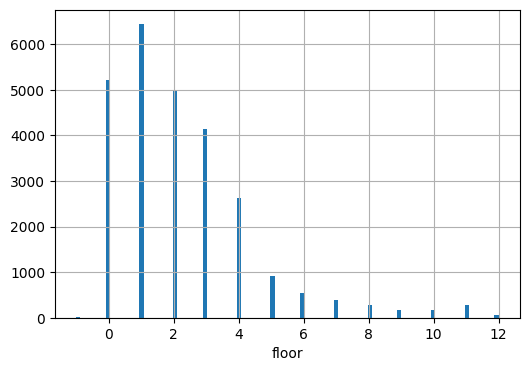

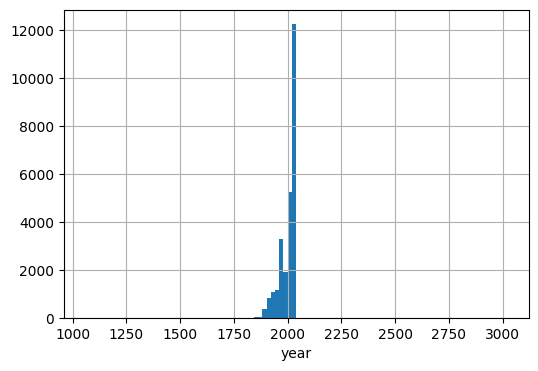

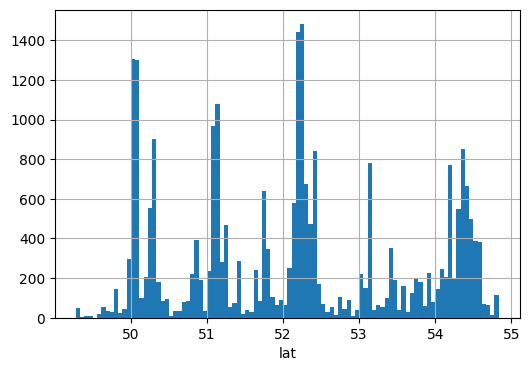

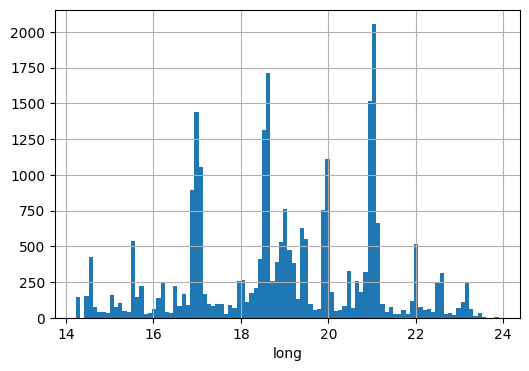

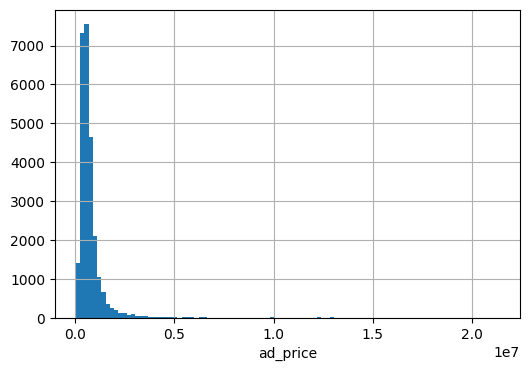

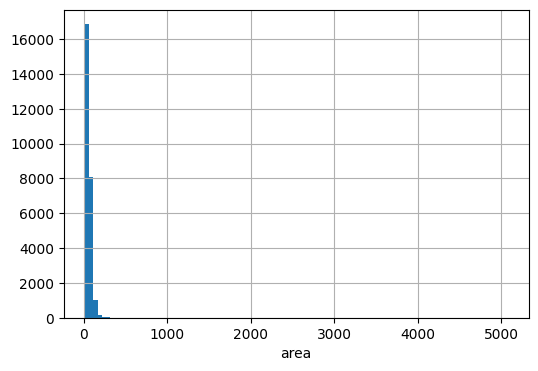

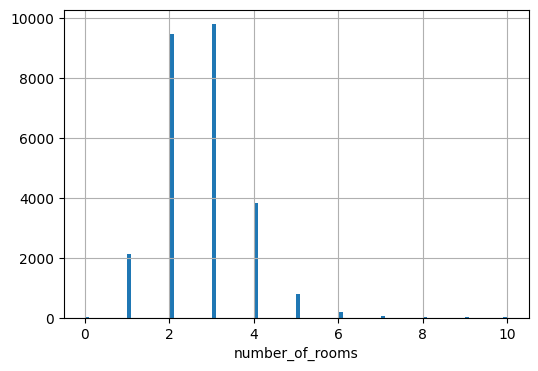

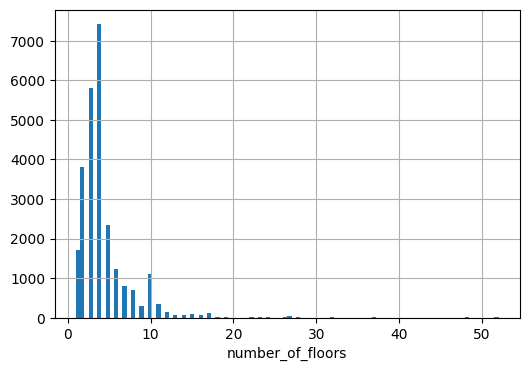

In [843]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
for column in numerical_columns:
    if all(value in [0, 1] for value in df[column].unique()):
        continue
    plt.figure(figsize=(6, 4))
    plt.hist(df[column], bins=100)
    plt.xlabel(column)
    plt.grid(True)
    plt.show()

### Outliers

In [844]:
from scipy.stats import zscore

def get_outliers_zscore(df, threshold=3):
    result = {}
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    for column in numerical_columns:
        if all(value in [0, 1] for value in df[column].unique()):
            continue
        outliers = df[abs(zscore(df[column])) > threshold]
        num_outliers = len(outliers)
        if num_outliers:
            result.update({column: {'num': num_outliers, 'values': outliers}})
    return result

def get_outliers_iqr(df):
    result = {}
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    for column in numerical_columns:
        if all(value in [0, 1] for value in df[column].unique()):
            continue
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
        num_outliers = len(outliers)
        if num_outliers:
            result.update({column: {'num': num_outliers, 'values': outliers}})
    return result

def remove_outliers_iqr(df):
    outliers_columns = get_outliers_iqr(df).keys()
    df_filtered = df.copy()
    for column in outliers_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]
    return df_filtered

def remove_outliers_zscore(df):
    outliers_columns = get_outliers_zscore(df).keys()
    return df[(np.abs(zscore(df[outliers_columns])) < 3).all(axis=1)]

In [845]:
outliers_zscore = get_outliers_zscore(df)
outliers_iqr = get_outliers_iqr(df)

In [846]:
for k, v in outliers_zscore.items():
    print(k, v['num'])

floor 691
year 149
ad_price 417
area 136
number_of_rooms 248
number_of_floors 415


In [847]:
for k, v in outliers_iqr.items():
    print(k, v['num'])

floor 1342
year 975
ad_price 1776
area 1380
number_of_rooms 1062
number_of_floors 2428


In [848]:
df_zscore = remove_outliers_zscore(df)

In [849]:
df_zscore.__len__()

24609

In [850]:
df_iqr = remove_outliers_iqr(df)

In [851]:
df_iqr.__len__()

20263

In [852]:
df = df_iqr

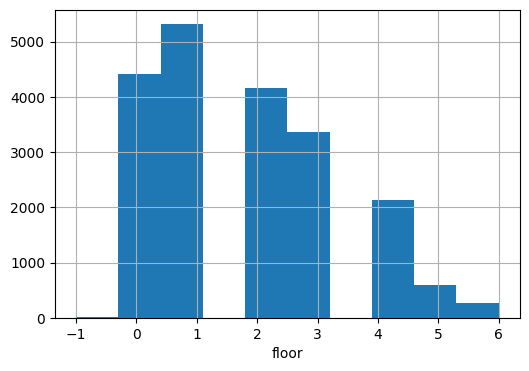

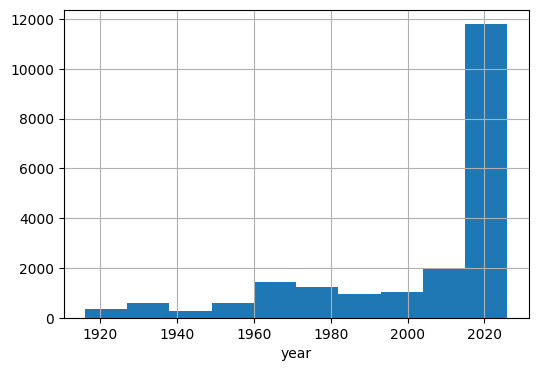

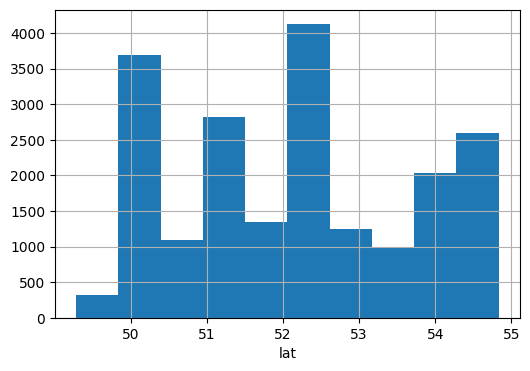

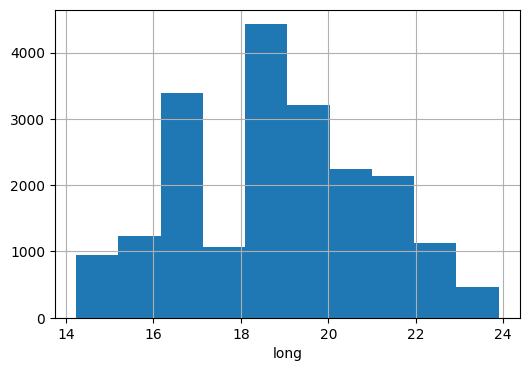

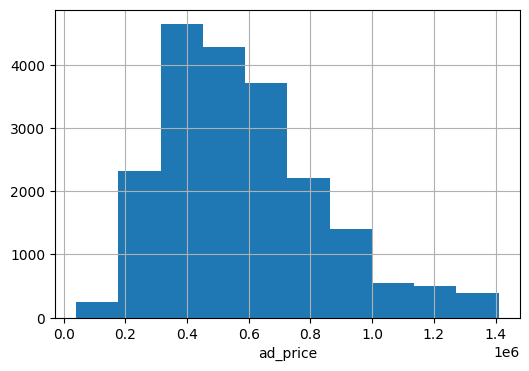

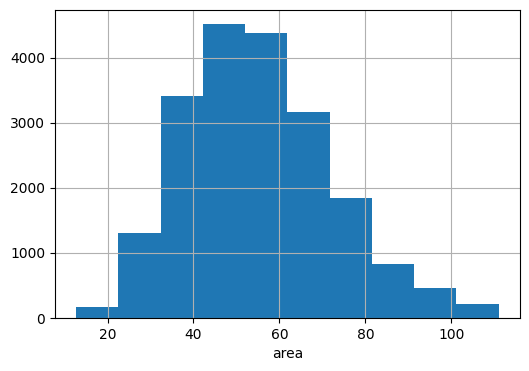

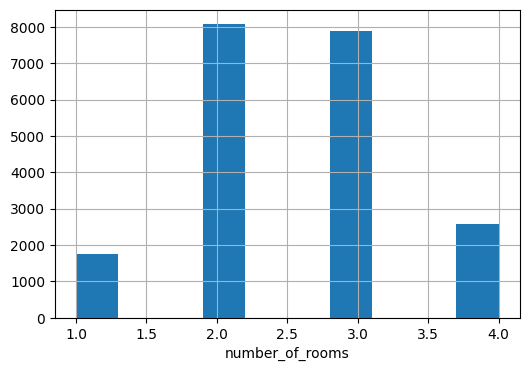

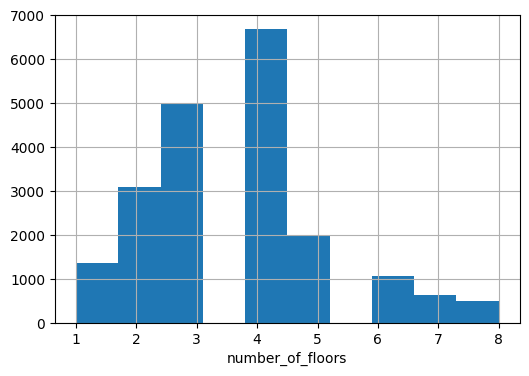

In [853]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
for column in numerical_columns:
    if all(value in [0, 1] for value in df[column].unique()):
        continue
    plt.figure(figsize=(6, 4))
    plt.hist(df[column], bins=10)
    plt.xlabel(column)
    plt.grid(True)
    plt.show()